### Assignment 1 (2 scores):
- Use Numpy only to implement the Gaussian Mixture Model.
- Train Gaussian Mixture Model with EM method.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import cv2

In [2]:
import numpy as np

class GMM:
    def __init__(self, n_components, max_iter=100, comp_names=None):
        self.n_components = n_components
        self.max_iter = max_iter

        if comp_names is None:
            self.comp_names = [f"comp_{i}" for i in range(self.n_components)]
        else:
            self.comp_names = comp_names

    def multivariate_normal(self, x, mean, cov):
        d = x.shape[0]
        cov_inv = np.linalg.inv(cov)
        norm_const = 1.0 / (np.power((2 * np.pi), d / 2) * np.sqrt(np.linalg.det(cov)))
        x_mu = x - mean
        result = np.exp(-0.5 * np.dot(x_mu.T, np.dot(cov_inv, x_mu)))
        return norm_const * result

    def fit(self, X):
        X = np.asarray(X)
        n_samples, n_features = X.shape

        # Initialize means, covariances, and priors
        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices]
        self.covs = [np.cov(X.T) + np.eye(n_features)*1e-6 for _ in range(self.n_components)]
        self.pi = np.ones(self.n_components) / self.n_components

        for _ in range(self.max_iter):
            # E-step
            r = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                for n in range(n_samples):
                    r[n, k] = self.pi[k] * self.multivariate_normal(X[n], self.means[k], self.covs[k])
            r = r / r.sum(axis=1, keepdims=True)

            # M-step
            N_k = np.sum(r, axis=0)
            self.pi = N_k / n_samples

            self.means = np.dot(r.T, X) / N_k[:, np.newaxis]

            for k in range(self.n_components):
                diff = X - self.means[k]
                self.covs[k] = np.dot(r[:, k] * diff.T, diff) / N_k[k]
                self.covs[k] += np.eye(n_features) * 1e-6  # regularization for stability

    def predict(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            for n in range(n_samples):
                responsibilities[n, k] = self.pi[k] * self.multivariate_normal(X[n], self.means[k], self.covs[k])
        labels = np.argmax(responsibilities, axis=1)
        return labels


In [3]:
# Load and reshape image
img = cv2.imread('cow.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, c = img_rgb.shape
X = img_rgb.reshape(-1, 3)

# Train GMM
gmm = GMM(n_components=3, max_iter=20)
gmm.fit(X)
labels = gmm.predict(X)

### Assignment 2 (2 scores):

Use the Gaussian Mixture Model to filter out background of a given image.

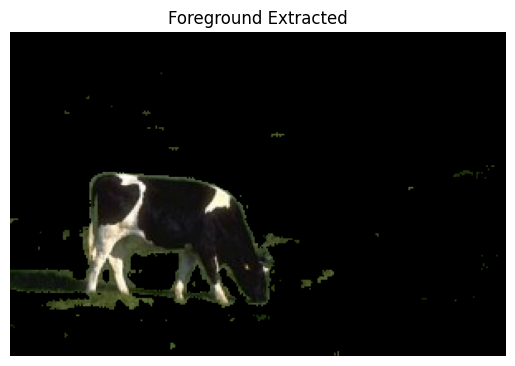

In [4]:
# Assume background is the cluster with largest size
unique, counts = np.unique(labels, return_counts=True)
background_label = unique[np.argmax(counts)]

# Filter background
mask = labels != background_label
X_foreground = X.copy()
X_foreground[~mask] = [0, 0, 0]  # make background black

# Show result
foreground_img = X_foreground.reshape(h, w, 3)
plt.imshow(foreground_img)
plt.axis('off')
plt.title('Foreground Extracted')
plt.show()
